# Mixed States Reconstruction (Infidelity as loss)

In [124]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [125]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation (Haar Distribution)

In [126]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [127]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [128]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [129]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand()**(1/3)* bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [130]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [131]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [132]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [159]:
#define loss function
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)


   numer = tf.math.abs(tf.linalg.trace(tf.matmul(rho_a, rho_b)))
   den = tf.math.sqrt(tf.linalg.trace(tf.linalg.matmul(rho_a, rho_a)) * tf.linalg.trace(tf.linalg.matmul(rho_b, rho_b)))
   numer = tf.cast(numer, tf.complex64)
   infidelity = 1 - numer/den
   return infidelity

In [153]:
print(tf.math.abs(tf.linalg.trace(tf.matmul(Y_tf, Y_tf))))
print(tf.linalg.matmul(Y_tf, Y_tf))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]], shape=(2, 2), dtype=complex64)


In [134]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [135]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [136]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [137]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [138]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [139]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [140]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [141]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [142]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [143]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [144]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [145]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [184]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:400], bloch_vectors_with_noise[900:950], bloch_vectors_with_noise[950:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:400], bloch_vectors_noise_free[900:950], bloch_vectors_noise_free[950:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [185]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [186]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a *b
  return output

In [187]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(128, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x) #con sigmoid processo stabile, con ReLU instabile, con niente fidelity più alta
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal) #normal


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 dense_54 (Dense)               (None, 128)          512         ['input_37[0][0]']               
                                                                                                  
 dense_55 (Dense)               (None, 64)           8256        ['dense_54[0][0]']               
                                                                                                  
 dense_56 (Dense)               (None, 16)           1040        ['dense_55[0][0]']               
                                                                                           

In [188]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.00003)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=inf)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=80, epochs=2000)

Epoch 1/2000
5/5 [==============================] - 4s 96ms/step - loss: 0.3779 - val_loss: 0.3389
Epoch 2/2000
5/5 [==============================] - 0s 25ms/step - loss: 0.3718 - val_loss: 0.3313
Epoch 3/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.3654 - val_loss: 0.3241
Epoch 4/2000
5/5 [==============================] - 0s 20ms/step - loss: 0.3592 - val_loss: 0.3170
Epoch 5/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.3527 - val_loss: 0.3102
Epoch 6/2000
5/5 [==============================] - 0s 29ms/step - loss: 0.3458 - val_loss: 0.3038
Epoch 7/2000
5/5 [==============================] - 0s 20ms/step - loss: 0.3392 - val_loss: 0.2976
Epoch 8/2000
5/5 [==============================] - 0s 22ms/step - loss: 0.3325 - val_loss: 0.2917
Epoch 9/2000
5/5 [==============================] - 0s 23ms/step - loss: 0.3250 - val_loss: 0.2861
Epoch 10/2000
5/5 [==============================] - 0s 20ms/step - loss: 0.3180 - val_loss: 0.2806
Epoch 11/

5/5 [==============================] - 0s 21ms/step - loss: 0.0093 - val_loss: 0.0122
Epoch 84/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.0090 - val_loss: 0.0119
Epoch 85/2000
5/5 [==============================] - 0s 20ms/step - loss: 0.0088 - val_loss: 0.0117
Epoch 86/2000
5/5 [==============================] - 0s 25ms/step - loss: 0.0085 - val_loss: 0.0114
Epoch 87/2000
5/5 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0112
Epoch 88/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.0081 - val_loss: 0.0110
Epoch 89/2000
5/5 [==============================] - 0s 21ms/step - loss: 0.0078 - val_loss: 0.0108
Epoch 90/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.0076 - val_loss: 0.0106
Epoch 91/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 92/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0072 - val_loss: 0.0102
Epoch 93/2000


5/5 [==============================] - 0s 22ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 165/2000
5/5 [==============================] - 0s 24ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 166/2000
5/5 [==============================] - 0s 24ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 167/2000
5/5 [==============================] - 0s 23ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 168/2000
5/5 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 169/2000
5/5 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 170/2000
5/5 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 171/2000
5/5 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 172/2000
5/5 [==============================] - 0s 23ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 173/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch

5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 246/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 247/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 248/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 249/2000
5/5 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 250/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 251/2000
5/5 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 252/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 253/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 254/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch

5/5 [==============================] - 0s 18ms/step - loss: 7.8997e-04 - val_loss: 0.0015
Epoch 325/2000
5/5 [==============================] - 0s 18ms/step - loss: 7.8638e-04 - val_loss: 0.0015
Epoch 326/2000
5/5 [==============================] - 0s 18ms/step - loss: 7.8180e-04 - val_loss: 0.0015
Epoch 327/2000
5/5 [==============================] - 0s 20ms/step - loss: 7.7907e-04 - val_loss: 0.0015
Epoch 328/2000
5/5 [==============================] - 0s 22ms/step - loss: 7.7485e-04 - val_loss: 0.0015
Epoch 329/2000
5/5 [==============================] - 0s 18ms/step - loss: 7.7047e-04 - val_loss: 0.0015
Epoch 330/2000
5/5 [==============================] - 0s 24ms/step - loss: 7.6698e-04 - val_loss: 0.0015
Epoch 331/2000
5/5 [==============================] - 0s 18ms/step - loss: 7.6281e-04 - val_loss: 0.0015
Epoch 332/2000
5/5 [==============================] - 0s 18ms/step - loss: 7.5939e-04 - val_loss: 0.0015
Epoch 333/2000
5/5 [==============================] - 0s 18ms/step - l

5/5 [==============================] - 0s 17ms/step - loss: 5.5509e-04 - val_loss: 0.0011
Epoch 403/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.5229e-04 - val_loss: 0.0011
Epoch 404/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.5077e-04 - val_loss: 0.0011
Epoch 405/2000
5/5 [==============================] - 0s 19ms/step - loss: 5.4731e-04 - val_loss: 0.0011
Epoch 406/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.4547e-04 - val_loss: 0.0011
Epoch 407/2000
5/5 [==============================] - 0s 17ms/step - loss: 5.4284e-04 - val_loss: 0.0011
Epoch 408/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.4120e-04 - val_loss: 0.0011
Epoch 409/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.3848e-04 - val_loss: 0.0011
Epoch 410/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.3634e-04 - val_loss: 0.0011
Epoch 411/2000
5/5 [==============================] - 0s 17ms/step - l

5/5 [==============================] - 0s 17ms/step - loss: 4.1539e-04 - val_loss: 8.3553e-04
Epoch 479/2000
5/5 [==============================] - 0s 18ms/step - loss: 4.1388e-04 - val_loss: 8.2953e-04
Epoch 480/2000
5/5 [==============================] - 0s 18ms/step - loss: 4.1268e-04 - val_loss: 8.1347e-04
Epoch 481/2000
5/5 [==============================] - 0s 18ms/step - loss: 4.1108e-04 - val_loss: 8.1307e-04
Epoch 482/2000
5/5 [==============================] - 0s 18ms/step - loss: 4.0948e-04 - val_loss: 8.1501e-04
Epoch 483/2000
5/5 [==============================] - 0s 18ms/step - loss: 4.0811e-04 - val_loss: 8.1249e-04
Epoch 484/2000
5/5 [==============================] - 0s 18ms/step - loss: 4.0675e-04 - val_loss: 8.1173e-04
Epoch 485/2000
5/5 [==============================] - 0s 18ms/step - loss: 4.0490e-04 - val_loss: 8.0962e-04
Epoch 486/2000
5/5 [==============================] - 0s 19ms/step - loss: 4.0386e-04 - val_loss: 8.0092e-04
Epoch 487/2000
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 3.2001e-04 - val_loss: 6.5484e-04
Epoch 554/2000
5/5 [==============================] - 0s 20ms/step - loss: 3.1838e-04 - val_loss: 6.5603e-04
Epoch 555/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.1815e-04 - val_loss: 6.5783e-04
Epoch 556/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.1650e-04 - val_loss: 6.5339e-04
Epoch 557/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.1571e-04 - val_loss: 6.4446e-04
Epoch 558/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.1440e-04 - val_loss: 6.4405e-04
Epoch 559/2000
5/5 [==============================] - 0s 21ms/step - loss: 3.1297e-04 - val_loss: 6.4238e-04
Epoch 560/2000
5/5 [==============================] - 0s 19ms/step - loss: 3.1222e-04 - val_loss: 6.4547e-04
Epoch 561/2000
5/5 [==============================] - 0s 22ms/step - loss: 3.1095e-04 - val_loss: 6.4076e-04
Epoch 562/2000
5/5 [==============

5/5 [==============================] - 0s 17ms/step - loss: 2.5278e-04 - val_loss: 5.3207e-04
Epoch 629/2000
5/5 [==============================] - 0s 20ms/step - loss: 2.5214e-04 - val_loss: 5.3427e-04
Epoch 630/2000
5/5 [==============================] - 0s 20ms/step - loss: 2.5233e-04 - val_loss: 5.3226e-04
Epoch 631/2000
5/5 [==============================] - 0s 23ms/step - loss: 2.5075e-04 - val_loss: 5.2630e-04
Epoch 632/2000
5/5 [==============================] - 0s 23ms/step - loss: 2.5006e-04 - val_loss: 5.2094e-04
Epoch 633/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.4946e-04 - val_loss: 5.2546e-04
Epoch 634/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.4895e-04 - val_loss: 5.2444e-04
Epoch 635/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.4771e-04 - val_loss: 5.2082e-04
Epoch 636/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.4729e-04 - val_loss: 5.1873e-04
Epoch 637/2000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 2.0538e-04 - val_loss: 4.5773e-04
Epoch 704/2000
5/5 [==============================] - 0s 19ms/step - loss: 2.0428e-04 - val_loss: 4.5409e-04
Epoch 705/2000
5/5 [==============================] - 0s 19ms/step - loss: 2.0393e-04 - val_loss: 4.5498e-04
Epoch 706/2000
5/5 [==============================] - 0s 22ms/step - loss: 2.0334e-04 - val_loss: 4.5410e-04
Epoch 707/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.0256e-04 - val_loss: 4.5316e-04
Epoch 708/2000
5/5 [==============================] - 0s 19ms/step - loss: 2.0266e-04 - val_loss: 4.5224e-04
Epoch 709/2000
5/5 [==============================] - 0s 20ms/step - loss: 2.0183e-04 - val_loss: 4.5347e-04
Epoch 710/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0126e-04 - val_loss: 4.5033e-04
Epoch 711/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0029e-04 - val_loss: 4.5230e-04
Epoch 712/2000
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 1.6772e-04 - val_loss: 4.0453e-04
Epoch 779/2000
5/5 [==============================] - 0s 20ms/step - loss: 1.6718e-04 - val_loss: 3.9722e-04
Epoch 780/2000
5/5 [==============================] - 0s 17ms/step - loss: 1.6650e-04 - val_loss: 3.9942e-04
Epoch 781/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6646e-04 - val_loss: 4.0123e-04
Epoch 782/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6628e-04 - val_loss: 4.0747e-04
Epoch 783/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6566e-04 - val_loss: 3.9576e-04
Epoch 784/2000
5/5 [==============================] - 0s 20ms/step - loss: 1.6503e-04 - val_loss: 3.9282e-04
Epoch 785/2000
5/5 [==============================] - 0s 22ms/step - loss: 1.6460e-04 - val_loss: 3.9481e-04
Epoch 786/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6379e-04 - val_loss: 3.9760e-04
Epoch 787/2000
5/5 [==============

5/5 [==============================] - 0s 23ms/step - loss: 1.3816e-04 - val_loss: 3.5230e-04
Epoch 854/2000
5/5 [==============================] - 0s 19ms/step - loss: 1.3744e-04 - val_loss: 3.5443e-04
Epoch 855/2000
5/5 [==============================] - 0s 19ms/step - loss: 1.3765e-04 - val_loss: 3.5349e-04
Epoch 856/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.3700e-04 - val_loss: 3.5335e-04
Epoch 857/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.3682e-04 - val_loss: 3.5369e-04
Epoch 858/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.3621e-04 - val_loss: 3.4984e-04
Epoch 859/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.3608e-04 - val_loss: 3.4886e-04
Epoch 860/2000
5/5 [==============================] - 0s 19ms/step - loss: 1.3558e-04 - val_loss: 3.4983e-04
Epoch 861/2000
5/5 [==============================] - 0s 20ms/step - loss: 1.3664e-04 - val_loss: 3.5065e-04
Epoch 862/2000
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 1.1483e-04 - val_loss: 3.1573e-04
Epoch 929/2000
5/5 [==============================] - 0s 21ms/step - loss: 1.1464e-04 - val_loss: 3.1714e-04
Epoch 930/2000
5/5 [==============================] - 0s 20ms/step - loss: 1.1426e-04 - val_loss: 3.1797e-04
Epoch 931/2000
5/5 [==============================] - 0s 17ms/step - loss: 1.1386e-04 - val_loss: 3.1614e-04
Epoch 932/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.1386e-04 - val_loss: 3.1396e-04
Epoch 933/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.1351e-04 - val_loss: 3.1839e-04
Epoch 934/2000
5/5 [==============================] - 0s 19ms/step - loss: 1.1371e-04 - val_loss: 3.1716e-04
Epoch 935/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.1272e-04 - val_loss: 3.1022e-04
Epoch 936/2000
5/5 [==============================] - 0s 22ms/step - loss: 1.1282e-04 - val_loss: 3.1188e-04
Epoch 937/2000
5/5 [==============

5/5 [==============================] - 0s 19ms/step - loss: 9.6359e-05 - val_loss: 2.8700e-04
Epoch 1004/2000
5/5 [==============================] - 0s 20ms/step - loss: 9.6187e-05 - val_loss: 2.8429e-04
Epoch 1005/2000
5/5 [==============================] - 0s 19ms/step - loss: 9.6314e-05 - val_loss: 2.8174e-04
Epoch 1006/2000
5/5 [==============================] - 0s 19ms/step - loss: 9.5795e-05 - val_loss: 2.8380e-04
Epoch 1007/2000
5/5 [==============================] - 0s 18ms/step - loss: 9.5556e-05 - val_loss: 2.8623e-04
Epoch 1008/2000
5/5 [==============================] - 0s 18ms/step - loss: 9.5111e-05 - val_loss: 2.7923e-04
Epoch 1009/2000
5/5 [==============================] - 0s 18ms/step - loss: 9.5121e-05 - val_loss: 2.8039e-04
Epoch 1010/2000
5/5 [==============================] - 0s 20ms/step - loss: 9.5699e-05 - val_loss: 2.8576e-04
Epoch 1011/2000
5/5 [==============================] - 0s 22ms/step - loss: 9.5258e-05 - val_loss: 2.8006e-04
Epoch 1012/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 8.0678e-05 - val_loss: 2.6110e-04
Epoch 1078/2000
5/5 [==============================] - 0s 18ms/step - loss: 8.0583e-05 - val_loss: 2.6340e-04
Epoch 1079/2000
5/5 [==============================] - 0s 17ms/step - loss: 8.0771e-05 - val_loss: 2.5885e-04
Epoch 1080/2000
5/5 [==============================] - 0s 20ms/step - loss: 8.0606e-05 - val_loss: 2.6063e-04
Epoch 1081/2000
5/5 [==============================] - 0s 17ms/step - loss: 8.0346e-05 - val_loss: 2.6261e-04
Epoch 1082/2000
5/5 [==============================] - 0s 19ms/step - loss: 8.0374e-05 - val_loss: 2.6385e-04
Epoch 1083/2000
5/5 [==============================] - 0s 19ms/step - loss: 8.0555e-05 - val_loss: 2.6139e-04
Epoch 1084/2000
5/5 [==============================] - 0s 18ms/step - loss: 7.9808e-05 - val_loss: 2.6228e-04
Epoch 1085/2000
5/5 [==============================] - 0s 18ms/step - loss: 7.9351e-05 - val_loss: 2.5566e-04
Epoch 1086/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 6.8935e-05 - val_loss: 2.4470e-04
Epoch 1152/2000
5/5 [==============================] - 0s 20ms/step - loss: 6.8399e-05 - val_loss: 2.4832e-04
Epoch 1153/2000
5/5 [==============================] - 0s 17ms/step - loss: 6.8748e-05 - val_loss: 2.4457e-04
Epoch 1154/2000
5/5 [==============================] - 0s 18ms/step - loss: 6.8234e-05 - val_loss: 2.4534e-04
Epoch 1155/2000
5/5 [==============================] - 0s 17ms/step - loss: 6.8150e-05 - val_loss: 2.4625e-04
Epoch 1156/2000
5/5 [==============================] - 0s 18ms/step - loss: 6.7817e-05 - val_loss: 2.4299e-04
Epoch 1157/2000
5/5 [==============================] - 0s 19ms/step - loss: 6.8031e-05 - val_loss: 2.4505e-04
Epoch 1158/2000
5/5 [==============================] - 0s 18ms/step - loss: 6.7469e-05 - val_loss: 2.4353e-04
Epoch 1159/2000
5/5 [==============================] - 0s 18ms/step - loss: 6.7273e-05 - val_loss: 2.4714e-04
Epoch 1160/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 5.8984e-05 - val_loss: 2.3022e-04
Epoch 1226/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.8604e-05 - val_loss: 2.3139e-04
Epoch 1227/2000
5/5 [==============================] - 0s 22ms/step - loss: 5.8666e-05 - val_loss: 2.3195e-04
Epoch 1228/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.8819e-05 - val_loss: 2.3197e-04
Epoch 1229/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.8431e-05 - val_loss: 2.3135e-04
Epoch 1230/2000
5/5 [==============================] - 0s 20ms/step - loss: 5.8947e-05 - val_loss: 2.3252e-04
Epoch 1231/2000
5/5 [==============================] - 0s 20ms/step - loss: 5.8211e-05 - val_loss: 2.3075e-04
Epoch 1232/2000
5/5 [==============================] - 0s 19ms/step - loss: 5.8083e-05 - val_loss: 2.3349e-04
Epoch 1233/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.8380e-05 - val_loss: 2.3186e-04
Epoch 1234/2000
5/5 [=====

5/5 [==============================] - 0s 20ms/step - loss: 5.1324e-05 - val_loss: 2.1826e-04
Epoch 1300/2000
5/5 [==============================] - 0s 22ms/step - loss: 5.0875e-05 - val_loss: 2.2167e-04
Epoch 1301/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.0934e-05 - val_loss: 2.2026e-04
Epoch 1302/2000
5/5 [==============================] - 0s 17ms/step - loss: 5.0665e-05 - val_loss: 2.2120e-04
Epoch 1303/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.0825e-05 - val_loss: 2.2158e-04
Epoch 1304/2000
5/5 [==============================] - 0s 20ms/step - loss: 5.0576e-05 - val_loss: 2.1877e-04
Epoch 1305/2000
5/5 [==============================] - 0s 19ms/step - loss: 5.0343e-05 - val_loss: 2.1886e-04
Epoch 1306/2000
5/5 [==============================] - 0s 17ms/step - loss: 5.0287e-05 - val_loss: 2.1939e-04
Epoch 1307/2000
5/5 [==============================] - 0s 18ms/step - loss: 5.0373e-05 - val_loss: 2.2098e-04
Epoch 1308/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 4.3940e-05 - val_loss: 2.1071e-04
Epoch 1374/2000
5/5 [==============================] - 0s 21ms/step - loss: 4.3931e-05 - val_loss: 2.1184e-04
Epoch 1375/2000
5/5 [==============================] - 0s 19ms/step - loss: 4.3491e-05 - val_loss: 2.1086e-04
Epoch 1376/2000
5/5 [==============================] - 0s 21ms/step - loss: 4.4063e-05 - val_loss: 2.1167e-04
Epoch 1377/2000
5/5 [==============================] - 0s 17ms/step - loss: 4.3805e-05 - val_loss: 2.1037e-04
Epoch 1378/2000
5/5 [==============================] - 0s 17ms/step - loss: 4.3885e-05 - val_loss: 2.1320e-04
Epoch 1379/2000
5/5 [==============================] - 0s 22ms/step - loss: 4.3667e-05 - val_loss: 2.0747e-04
Epoch 1380/2000
5/5 [==============================] - 0s 19ms/step - loss: 4.3433e-05 - val_loss: 2.1238e-04
Epoch 1381/2000
5/5 [==============================] - 0s 22ms/step - loss: 4.3556e-05 - val_loss: 2.0816e-04
Epoch 1382/2000
5/5 [=====

5/5 [==============================] - 0s 20ms/step - loss: 3.8415e-05 - val_loss: 2.0009e-04
Epoch 1448/2000
5/5 [==============================] - 0s 20ms/step - loss: 3.8037e-05 - val_loss: 2.0254e-04
Epoch 1449/2000
5/5 [==============================] - 0s 21ms/step - loss: 3.8024e-05 - val_loss: 1.9927e-04
Epoch 1450/2000
5/5 [==============================] - 0s 24ms/step - loss: 3.8079e-05 - val_loss: 1.9765e-04
Epoch 1451/2000
5/5 [==============================] - 0s 21ms/step - loss: 3.7694e-05 - val_loss: 2.0243e-04
Epoch 1452/2000
5/5 [==============================] - 0s 17ms/step - loss: 3.7526e-05 - val_loss: 2.0322e-04
Epoch 1453/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.8041e-05 - val_loss: 2.0011e-04
Epoch 1454/2000
5/5 [==============================] - 0s 20ms/step - loss: 3.7366e-05 - val_loss: 2.0013e-04
Epoch 1455/2000
5/5 [==============================] - 0s 20ms/step - loss: 3.7577e-05 - val_loss: 2.0172e-04
Epoch 1456/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 3.3040e-05 - val_loss: 1.9179e-04
Epoch 1522/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.3045e-05 - val_loss: 1.9307e-04
Epoch 1523/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.3417e-05 - val_loss: 1.9339e-04
Epoch 1524/2000
5/5 [==============================] - 0s 20ms/step - loss: 3.3671e-05 - val_loss: 1.8897e-04
Epoch 1525/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.3396e-05 - val_loss: 1.9108e-04
Epoch 1526/2000
5/5 [==============================] - 0s 18ms/step - loss: 3.2961e-05 - val_loss: 1.9043e-04
Epoch 1527/2000
5/5 [==============================] - 0s 17ms/step - loss: 3.3411e-05 - val_loss: 1.9107e-04
Epoch 1528/2000
5/5 [==============================] - 0s 21ms/step - loss: 3.2764e-05 - val_loss: 1.9472e-04
Epoch 1529/2000
5/5 [==============================] - 0s 21ms/step - loss: 3.3062e-05 - val_loss: 1.9310e-04
Epoch 1530/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 2.9059e-05 - val_loss: 1.8751e-04
Epoch 1596/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.9101e-05 - val_loss: 1.8570e-04
Epoch 1597/2000
5/5 [==============================] - 0s 20ms/step - loss: 2.8831e-05 - val_loss: 1.8326e-04
Epoch 1598/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.8806e-05 - val_loss: 1.8430e-04
Epoch 1599/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.8861e-05 - val_loss: 1.8777e-04
Epoch 1600/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.8864e-05 - val_loss: 1.8436e-04
Epoch 1601/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.8859e-05 - val_loss: 1.8668e-04
Epoch 1602/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.9383e-05 - val_loss: 1.8213e-04
Epoch 1603/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.8997e-05 - val_loss: 1.8421e-04
Epoch 1604/2000
5/5 [=====

5/5 [==============================] - 0s 22ms/step - loss: 2.5568e-05 - val_loss: 1.7798e-04
Epoch 1670/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.5502e-05 - val_loss: 1.7697e-04
Epoch 1671/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.5416e-05 - val_loss: 1.7772e-04
Epoch 1672/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.5736e-05 - val_loss: 1.7913e-04
Epoch 1673/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.5392e-05 - val_loss: 1.7779e-04
Epoch 1674/2000
5/5 [==============================] - 0s 20ms/step - loss: 2.5548e-05 - val_loss: 1.7758e-04
Epoch 1675/2000
5/5 [==============================] - 0s 19ms/step - loss: 2.5390e-05 - val_loss: 1.7912e-04
Epoch 1676/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.5383e-05 - val_loss: 1.7677e-04
Epoch 1677/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.5874e-05 - val_loss: 1.7466e-04
Epoch 1678/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 2.3546e-05 - val_loss: 1.7587e-04
Epoch 1744/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.3020e-05 - val_loss: 1.6819e-04
Epoch 1745/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.2853e-05 - val_loss: 1.7085e-04
Epoch 1746/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.2986e-05 - val_loss: 1.7313e-04
Epoch 1747/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.2655e-05 - val_loss: 1.7052e-04
Epoch 1748/2000
5/5 [==============================] - 0s 19ms/step - loss: 2.2955e-05 - val_loss: 1.7447e-04
Epoch 1749/2000
5/5 [==============================] - 0s 17ms/step - loss: 2.2924e-05 - val_loss: 1.7029e-04
Epoch 1750/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.2640e-05 - val_loss: 1.7086e-04
Epoch 1751/2000
5/5 [==============================] - 0s 21ms/step - loss: 2.2699e-05 - val_loss: 1.7112e-04
Epoch 1752/2000
5/5 [=====

5/5 [==============================] - 0s 17ms/step - loss: 2.0508e-05 - val_loss: 1.6469e-04
Epoch 1818/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0457e-05 - val_loss: 1.6575e-04
Epoch 1819/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0384e-05 - val_loss: 1.6496e-04
Epoch 1820/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0744e-05 - val_loss: 1.6136e-04
Epoch 1821/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0656e-05 - val_loss: 1.6843e-04
Epoch 1822/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0306e-05 - val_loss: 1.6275e-04
Epoch 1823/2000
5/5 [==============================] - 0s 18ms/step - loss: 2.0435e-05 - val_loss: 1.6711e-04
Epoch 1824/2000
5/5 [==============================] - 0s 20ms/step - loss: 2.0563e-05 - val_loss: 1.6456e-04
Epoch 1825/2000
5/5 [==============================] - 0s 20ms/step - loss: 2.0007e-05 - val_loss: 1.6362e-04
Epoch 1826/2000
5/5 [=====

5/5 [==============================] - 0s 18ms/step - loss: 1.8834e-05 - val_loss: 1.6012e-04
Epoch 1892/2000
5/5 [==============================] - 0s 17ms/step - loss: 1.8673e-05 - val_loss: 1.5750e-04
Epoch 1893/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.8403e-05 - val_loss: 1.6473e-04
Epoch 1894/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.8111e-05 - val_loss: 1.5767e-04
Epoch 1895/2000
5/5 [==============================] - 0s 17ms/step - loss: 1.8397e-05 - val_loss: 1.5826e-04
Epoch 1896/2000
5/5 [==============================] - 0s 19ms/step - loss: 1.8590e-05 - val_loss: 1.6206e-04
Epoch 1897/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.8375e-05 - val_loss: 1.5746e-04
Epoch 1898/2000
5/5 [==============================] - 0s 17ms/step - loss: 1.8175e-05 - val_loss: 1.6353e-04
Epoch 1899/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.8433e-05 - val_loss: 1.5656e-04
Epoch 1900/2000
5/5 [=====

5/5 [==============================] - 0s 17ms/step - loss: 1.6983e-05 - val_loss: 1.5879e-04
Epoch 1966/2000
5/5 [==============================] - 0s 20ms/step - loss: 1.6293e-05 - val_loss: 1.5485e-04
Epoch 1967/2000
5/5 [==============================] - 0s 21ms/step - loss: 1.6456e-05 - val_loss: 1.6014e-04
Epoch 1968/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6510e-05 - val_loss: 1.5453e-04
Epoch 1969/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6359e-05 - val_loss: 1.5833e-04
Epoch 1970/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6225e-05 - val_loss: 1.5820e-04
Epoch 1971/2000
5/5 [==============================] - 0s 18ms/step - loss: 1.6564e-05 - val_loss: 1.5578e-04
Epoch 1972/2000
5/5 [==============================] - 0s 23ms/step - loss: 1.6267e-05 - val_loss: 1.6014e-04
Epoch 1973/2000
5/5 [==============================] - 0s 22ms/step - loss: 1.6618e-05 - val_loss: 1.5386e-04
Epoch 1974/2000
5/5 [=====

In [189]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

2/2 - 0s - loss: 2.0723e-04 - 54ms/epoch - 27ms/step


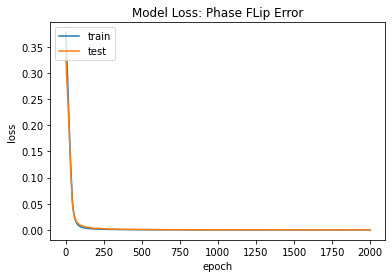

In [190]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [191]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9998217876643899-4.1707380046147254e-09j), shape=(), dtype=complex128)


(0.9999297751651284-4.941687720162709e-10j)
tf.Tensor([-0.63284045+0.j -0.2222026 +0.j  0.10681348+0.j], shape=(3,), dtype=complex64)
tf.Tensor([-0.62738603+0.j -0.23793179+0.j  0.10509714+0.j], shape=(3,), dtype=complex64)


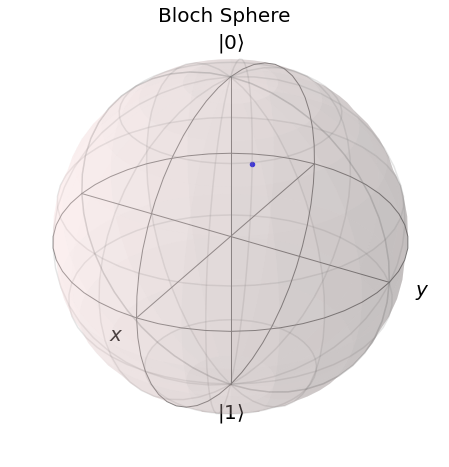

In [192]:
den_mat = rho_from_vec(y_prediction[0])
den_mat = np.asarray(den_mat)

den_mat_id = rho_from_vec(y_test[0])
den_mat_id = np.asarray(den_mat_id)

print(fidelity_function(den_mat_id, den_mat))


print(y_prediction[0])
print(y_test[0])

Bloch_sphere(y_prediction[:1])

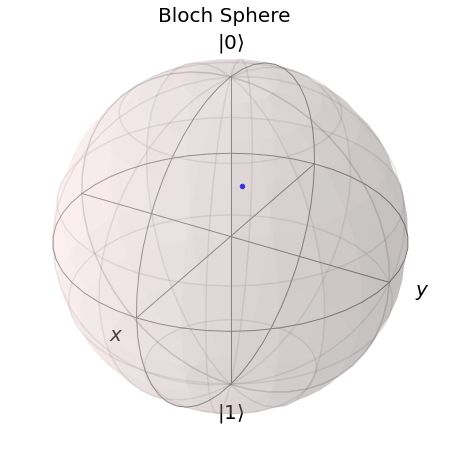

In [193]:
Bloch_sphere(x_test[:1])

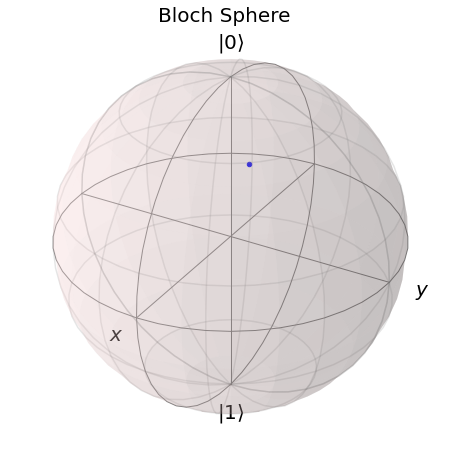

In [194]:
Bloch_sphere(y_test[:1])